# Low-Rank Adaptation (LoRA) from Scratch using PyTorch

In this notebook, we'll implement and train a small neural network using **Low-Rank Adaptation (LoRA)** in **PyTorch** without using Hugging Face.

---

## 📌 Step 1: Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

---

## 📌 Step 2: Generate a Toy Dataset

We'll use a synthetic linear dataset: \( y = 2x + 1 \)

In [2]:
# Generate synthetic data
x = torch.linspace(-10, 10, 200).unsqueeze(1)
y = 2 * x + 1 + torch.randn_like(x) * 2  # add noise

# Wrap in a DataLoader
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

---

## 📌 Step 3: Define LoRA Linear Layer

This is the core logic. We freeze the base layer and add two trainable low-rank matrices \( A \) and \( B \).

In [3]:
class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, r=4, alpha=1.0):
        super().__init__()
        self.base = nn.Linear(in_features, out_features, bias=False)
        self.base.weight.requires_grad = False  # freeze

        self.A = nn.Linear(in_features, r, bias=False)  # down projection
        self.B = nn.Linear(r, out_features, bias=False)  # up projection

        self.scaling = alpha / r

    def forward(self, x):
        return self.base(x) + self.B(self.A(x)) * self.scaling

---

## 📌 Step 4: Define the Model

In [4]:
class LoRAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lora = LoRALinear(1, 1, r=2, alpha=1.0)

    def forward(self, x):
        return self.lora(x)

---

## 📌 Step 5: Training the Model

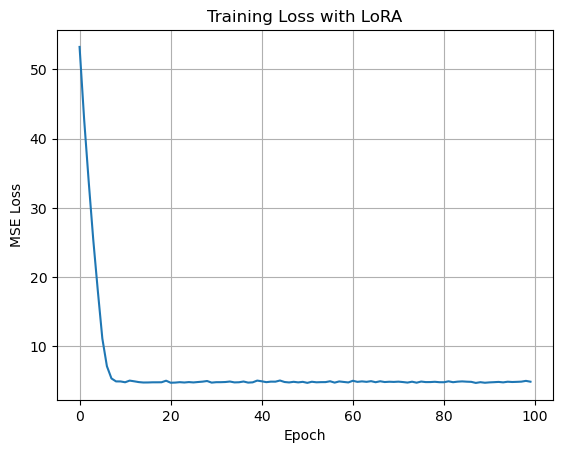

In [5]:
model = LoRAModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

epochs = 100
losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(dataloader))

# Plot the training loss
plt.plot(losses)
plt.title("Training Loss with LoRA")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

---

## 📌 Step 6: Evaluate the Model

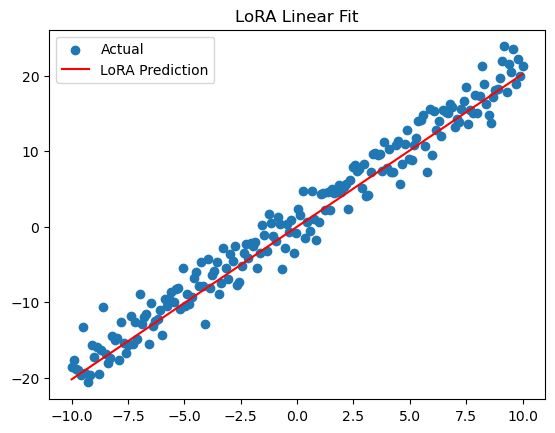

In [6]:
# Predict
model.eval()
with torch.no_grad():
    preds = model(x)

# Plot
plt.scatter(x.numpy(), y.numpy(), label='Actual')
plt.plot(x.numpy(), preds.numpy(), color='red', label='LoRA Prediction')
plt.legend()
plt.title("LoRA Linear Fit")
plt.show()

---

## ✅ Conclusion

This notebook demonstrated:
- How LoRA works internally.
- Its PyTorch implementation.
- How to fine-tune a small model efficiently using only a few parameters.

LoRA is particularly powerful when used with **very large models**—where training the full parameter set is infeasible.